## ✔️ Wczytujemy potrzebne biblioteki 

In [1]:
# Podstawowe biblioteki
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

# Przygotowanie danych
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder

# Modele
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

# Poprawa Modelu 
from sklearn.metrics import mean_absolute_error,mean_squared_error 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

# Wizualizacja
import scikitplot as skplt
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib 
%matplotlib inline
color = sns.color_palette()
import matplotlib.ticker as mtick
from IPython.display import display
pd.options.display.max_columns = None
from pandas.plotting import scatter_matrix

# Utilities
import os
import re
import sys
import string
import time
from datetime import datetime
from time import time
from scipy.stats import pointbiserialr
from tqdm import tqdm
import eli5
from eli5.sklearn import PermutationImportance
from hyperopt import hp, fmin, tpe, STATUS_OK, space_eval

## 💾 Wczytujemy dane

In [2]:
df_train = pd.read_hdf("../input/energy_train.h5")
df_test = pd.read_hdf("../input/energy_test.h5")

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26517 entries, 24 to 35227
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      26517 non-null  int64         
 1   date    26517 non-null  datetime64[ns]
 2   value   26517 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 828.7 KB


## Model podstawowy

Przypisanie sredniego zapotrzebowania energii wedlug miesiaca

In [4]:
df_temp = df_train.copy()
df_temp["date"] = pd.to_datetime(df_temp["date"])
df_temp["month"] = df_temp["date"].dt.month
df_energy_by_month = pd.DataFrame(df_temp[['month','value']].groupby('month').mean()).reset_index()

df_temp2 = df_test.copy()
df_temp2["date"] = pd.to_datetime(df_temp2["date"])
df_temp2["month"] = df_temp2["date"].dt.month
df_temp2 = pd.merge(df_temp2,df_energy_by_month, on = 'month')[['id','value']]

## ✔️ Zapisujemy wynik i dodajemy na Kaggle

In [5]:
df_temp2.to_csv("../output/model-podstawowy.csv", index=False)

Uzyskany wynik na Kaggle (MAE): 2695.06438

## 🕵️‍♀️ Sprawdzamy dane

In [6]:
df_train.head()

,id,date,value
24,24,2018-03-02 00:00:00,20842.538
25,25,2018-03-02 01:00:00,20108.125
26,26,2018-03-02 02:00:00,19480.463
27,27,2018-03-02 03:00:00,19235.275
28,28,2018-03-02 04:00:00,19149.388


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26517 entries, 24 to 35227
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      26517 non-null  int64         
 1   date    26517 non-null  datetime64[ns]
 2   value   26517 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 828.7 KB


In [8]:
df_train.describe()

,id,value
count,26517.000000,26517.000000
mean,17769.289626,19405.569279
std,10163.658233,3242.556600
min,24.000000,10768.725000
25%,8836.000000,16736.688000
50%,17961.000000,19450.300000
75%,26510.000000,21924.450000
max,35227.000000,27374.675000


In [9]:
print("Data range in train starts at: ", df_train['date'].min())
print("Data range in train ends at: ", df_train['date'].max())

print("Data range in test starts at: ", df_test['date'].min())
print("Data range in test ends at: ", df_test['date'].max())

Data range in train starts at:  2018-03-02 00:00:00
Data range in train ends at:  2022-03-07 23:00:00
Data range in test starts at:  2018-03-01 00:00:00
Data range in test ends at:  2022-03-08 23:00:00


Text(0.5, 1.0, 'Zmiana zapotrzebowania na energie w czasie')

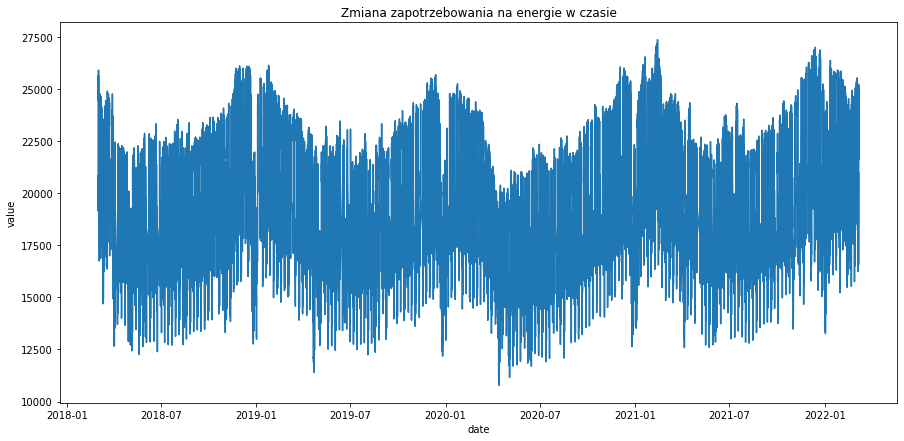

In [11]:
plt.figure(figsize=(15, 7))
sns.lineplot(x='date', y='value', data=df_train)
plt.title("Zmiana zapotrzebowania na energie w czasie")

## 💡 Pierwsze wnioski

- nie mamy brakujacych wartosci
- widac sezonowosc roczna

## Dodanie cech na podstawie daty

In [12]:
df_all = pd.concat([df_train, df_test])
df_all["date"] = pd.to_datetime(df_all["date"])

df_all.shape

(35252, 3)

In [13]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35252 entries, 24 to 35251
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      35252 non-null  int64         
 1   date    35252 non-null  datetime64[ns]
 2   value   26517 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.1 MB


In [15]:
def feature_engineering(df):
    # Date features
    df.sort_values(by='date', inplace=True)
    df["year"] =  df["date"].dt.year
    df["month"] =  df["date"].dt.month
    df["day"] =  df["date"].dt.day
    df["hour"] =  df["date"].dt.hour
    df["week"] =  df["date"].dt.week
    df["weekofyear"] =  df["date"].dt.weekofyear
    df["dayofweek"] =  df["date"].dt.dayofweek
    df["weekday"] =  df["date"].dt.weekday
    df["dayofyear"] =  df["date"].dt.dayofyear
    df["quarter"] =  df["date"].dt.quarter
    df["is_month_start"] =  df["date"].dt.is_month_start
    df["is_month_end"] =  df["date"].dt.is_month_end
    df["is_quarter_start"] =  df["date"].dt.is_quarter_start
    df["is_quarter_end"] =  df["date"].dt.is_quarter_end
    df["is_year_start"] =  df["date"].dt.is_year_start
    df["is_year_end"] =  df["date"].dt.is_year_end
    df["is_leap_year"] =  df["date"].dt.is_leap_year
    df["daysinmonth"] =  df["date"].dt.daysinmonth
    
    # statistics per groups
    df_train = df[ df.value.notnull() ]
    
    group_features = {
        "group_mean_hour_dayofweek": ["hour", "dayofweek"],
        "group_mean_hour_month": ["hour", "month"],
        "group_mean_hour_dayofweek_month": ["hour", "dayofweek", "month"],
    }
    
    for feat_name,group_keys in group_features.items(): 
        dict_group = {k:v["value"] for k,v in df_train[["value"] + group_keys].groupby(group_keys).agg("mean").to_dict(orient="items").items() }
        df[feat_name] = df[ group_keys ].apply(lambda keys: dict_group.get(tuple(keys)), axis=1)
        
    group_features2 = {
        "group_std_hour_dayofweek": ["hour", "dayofweek"],
        "group_std_hour_month": ["hour", "month"],
        "group_std_hour_dayofweek_month": ["hour", "dayofweek", "month"],
    }
    
    for feat_name,group_keys in group_features2.items(): 
        dict_group = {k:v["value"] for k,v in df_train[["value"] + group_keys].groupby(group_keys).agg("std").to_dict(orient="items").items() }
        df[feat_name] = df[ group_keys ].apply(lambda keys: dict_group.get(tuple(keys)), axis=1)
        
    # lagged values    
    df.index = df["date"]
    df_train = df[ df.value.notnull() ]
    
    #get value from yesterday 
    d = 1
    df_train_new = df_train.copy()
    feat_name = "dayofyear_{}d".format(d)
    value_feat_name = "value_{}dayofyear".format(d)

    df_train_new[feat_name] = df_train_new["dayofyear"] + d
    df_train_new.rename(columns={"value": value_feat_name}, inplace=True)

    df = pd.merge(df, df_train_new[ [value_feat_name, feat_name, "year", "hour"] ], left_on=["year", "dayofyear", "hour"], right_on=["year", feat_name, "hour"], how="left")
    
    return df
    
df_new = feature_engineering(df_all)

In [16]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35252 entries, 0 to 35251
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   id                               35252 non-null  int64         
 1   date                             35252 non-null  datetime64[ns]
 2   value                            26517 non-null  float64       
 3   year                             35252 non-null  int64         
 4   month                            35252 non-null  int64         
 5   day                              35252 non-null  int64         
 6   hour                             35252 non-null  int64         
 7   week                             35252 non-null  int64         
 8   weekofyear                       35252 non-null  int64         
 9   dayofweek                        35252 non-null  int64         
 10  weekday                          35252 non-null  int64    

Text(0.5, 1.0, 'Zmiana zapotrzebowania na energie w ciagu jednego dnia')

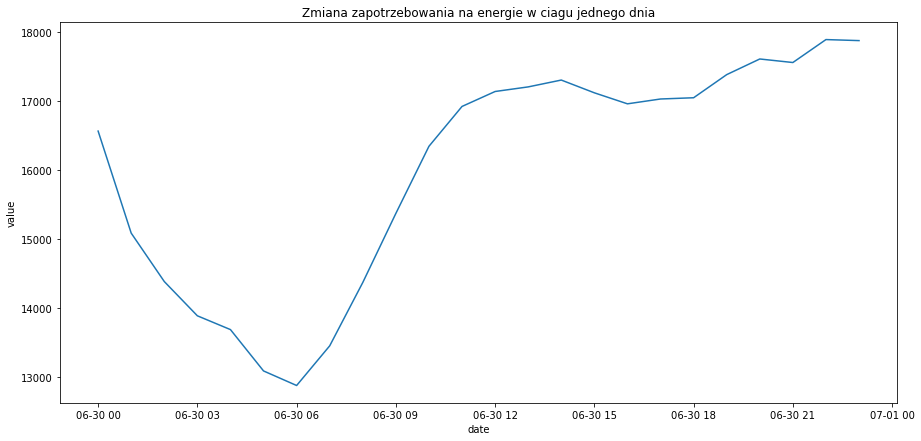

In [18]:
plt.figure(figsize=(15, 7))
sns.lineplot(x='date', y='value', data=df_new[(df_new["year"] == 2019) & (df_new["day"] == 30) & (df_new["month"] == 6)] )
plt.title("Zmiana zapotrzebowania na energie w ciagu jednego dnia")

In [19]:
df_all_statistics = df_new.copy()

In [20]:
feats = [col for col in df_all_statistics.columns if col not in ('id','date','value','dayofyear_1d')]

df_train = df_all_statistics[ df_all_statistics["value"].notnull() ]
df_test = df_all_statistics[ df_all_statistics["value"].isnull() ].copy()

X_train = df_train[feats].values
y_train = df_train["value"].values
X_test = df_test[feats].values

## 🤖 Trenujemy i prognozujemy 

In [21]:
def fit_predict_feat_importance(model):
    model.fit(X_train, y_train)
    y_pred =  model.predict(X_test)
    imp = PermutationImportance(model, random_state=0).fit(X_train,y_train)
    title='Feature Importance'
    skplt.estimators.plot_feature_importances(model, feature_names=feats, title=title, x_tick_rotation=90, figsize=(15, 5));
    res_eli5 = eli5.show_weights(imp, feature_names=feats, top=30)
    return res_eli5
# model = CatBoostRegressor(iterations = 100)
# #model = XGBRegressor()
# model.fit(X_train, y_train)
# df_test["value"] = model.predict(X_test)

Weight,Feature
1.1591 ± 0.0093,group_mean_hour_dayofweek_month
0.0778 ± 0.0014,value_1dayofyear
0.0539 ± 0.0009,dayofyear
0.0402 ± 0.0011,day
0.0274 ± 0.0009,group_std_hour_dayofweek_month
0.0271 ± 0.0005,year
0.0145 ± 0.0003,is_leap_year
0.0081 ± 0.0001,weekofyear
0.0076 ± 0.0002,week
0.0070 ± 0.0002,group_mean_hour_month


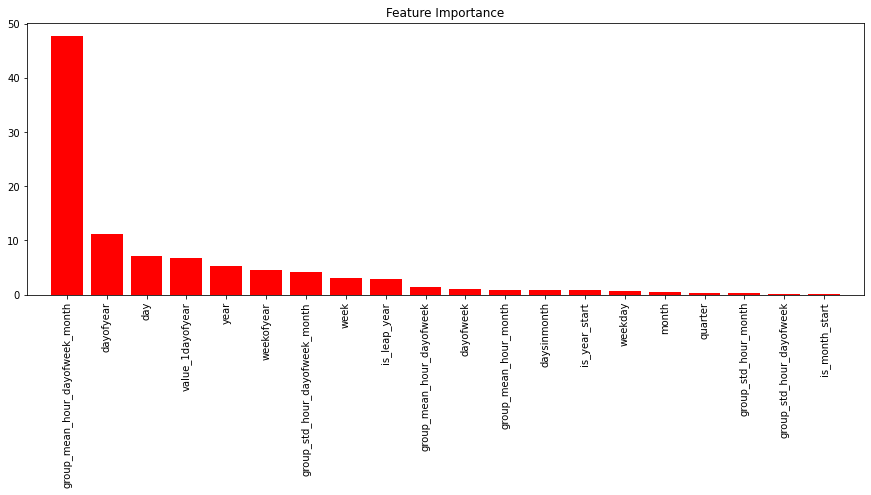

In [22]:
fit_predict_feat_importance(CatBoostRegressor(verbose = False))

Weight,Feature
1.2573 ± 0.0092,group_mean_hour_dayofweek_month
0.1005 ± 0.0014,value_1dayofyear
0.0814 ± 0.0023,dayofyear
0.0324 ± 0.0012,day
0.0242 ± 0.0005,year
0.0212 ± 0.0003,week
0.0201 ± 0.0003,group_std_hour_dayofweek_month
0.0170 ± 0.0004,dayofweek
0.0152 ± 0.0002,month
0.0115 ± 0.0002,is_leap_year


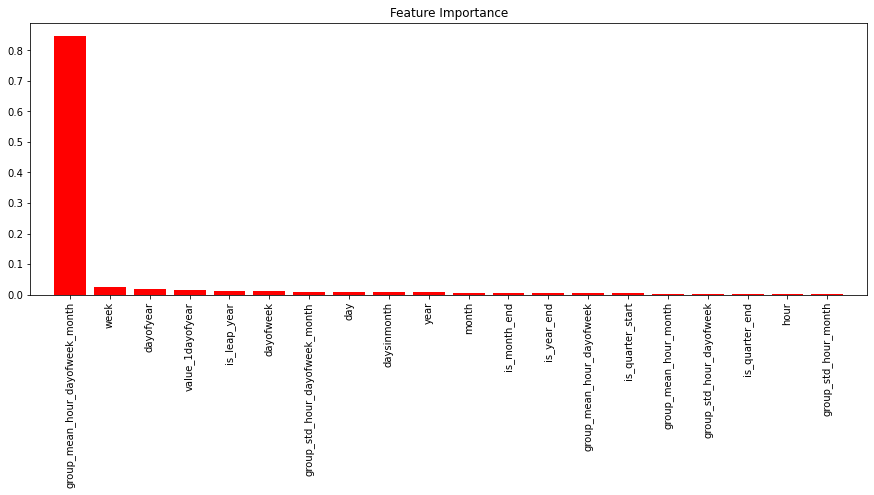

In [23]:
fit_predict_feat_importance(XGBRegressor())

## Walidacja

In [24]:
X = df_train.drop(['value'],axis = 1)[feats]
y = df_train['value']

In [26]:
scores = []
names = []
models = []

#tscv = TimeSeriesSplit(n_splits=5)
group_kfold = GroupKFold(n_splits=5)
#models.append(('Linear Regression', LinearRegression()))
#models.append(('Decision Tree', DecisionTreeRegressor(random_state = 0)))
#models.append(('Random Forest', RandomForestRegressor(random_state=0)))
models.append(('CatBoost', CatBoostRegressor(random_state= 0, verbose = 0)))
models.append(('XGBoost', XGBRegressor(random_state= 0, verbosity = 0)))

col = ['Algorithm','Mean of MAE', 'Std of MAE']
model_results = pd.DataFrame(columns=col)

i = 0

for name, model in tqdm(models):    

    mae_results = []

    #scores = []
    #for train_idx, test_idx in tscv.split(X,y):
    for train_idx, test_idx in group_kfold.split(X,y,X['day']):
        
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        print(X_train.shape,"-----", X_test.shape)
        
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        
        mae_results.append(mae)
        
    names.append(name)    
    scores.append(mae_results)
    model_results.loc[i] = [name,
                            round(np.mean(mae_results), 2),
                            round(np.mean(mae_results), 2)]
    i += 1

model_results.sort_values(by=['Mean of MAE'], ascending=False)

  0%|          | 0/2 [00:00<?, ?it/s]

(21285, 25) ----- (5232, 25)
(21262, 25) ----- (5255, 25)
(21286, 25) ----- (5231, 25)
(20950, 25) ----- (5567, 25)
(21285, 25) ----- (5232, 25)


 50%|█████     | 1/2 [00:20<00:20, 20.82s/it]

(21285, 25) ----- (5232, 25)
(21262, 25) ----- (5255, 25)
(21286, 25) ----- (5231, 25)
(20950, 25) ----- (5567, 25)
(21285, 25) ----- (5232, 25)


100%|██████████| 2/2 [00:41<00:00, 20.87s/it]


,Algorithm,Mean of MAE,Std of MAE
1,XGBoost,491.21,491.21
0,CatBoost,444.83,444.83


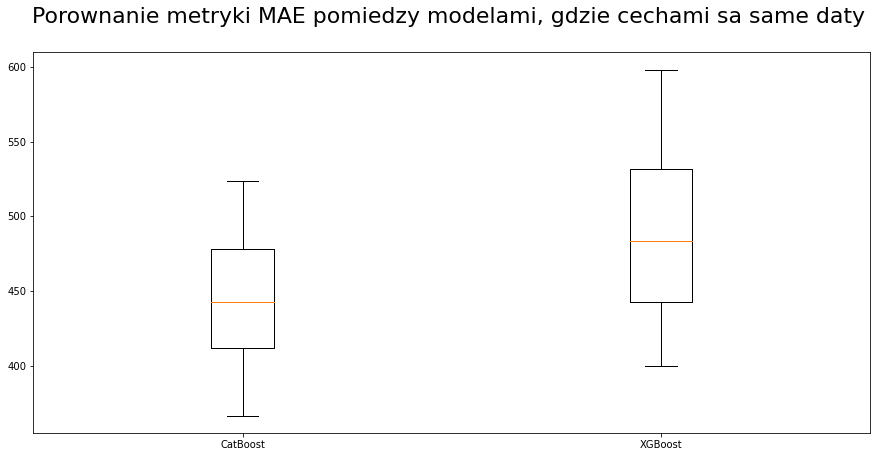

In [27]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(names)

plt.title('Porownanie metryki MAE pomiedzy modelami, gdzie cechami sa same daty \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

## Hyperopt

In [45]:
feats = [col for col in df_all_statistics.columns if col not in ('id','date','value','dayofyear_1d','group_std_hour_dayofweek',)]
#                                                                  'quarter', 'is_quarter_start', 'is_month_start','is_month_end',
#                                                                  'is_year_end')]

In [46]:
X = df_train.drop(['value'],axis = 1)[feats]
y = df_train['value']
X_test = df_test[feats].values

In [47]:
def run_model(model,X,y):
    group_kfold = GroupKFold(n_splits=5)
    mae_results = []    
    for train_idx, test_idx in group_kfold.split(X,y,X['day']):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        mae_results.append(mae)
        
        
    return np.mean(mae_results)

In [48]:
def obj_func(params):
    print(params)
    
    mae_score = run_model(XGBRegressor(**params),X,y)
    
    return{'loss': mae_score, 'status': STATUS_OK}

### XGBoost

In [29]:
xgb_reg_params = {
'learning_rate':     hp.choice('learning_rate',          np.arange(0.01,0.1,0.01)),
'max_depth':         hp.choice("max_depth",              np.arange(4,8,1,dtype = int)),
'colsample_bytree':  hp.uniform ('x_colsample_bytree', 0.8, 1.),
'subsample': hp.uniform ('x_subsample', 0.7, 1.),
'n_estimators': 120,
'verbosity': 0,
'seed': 0
}
best = fmin(obj_func,xgb_reg_params,algo = tpe.suggest,max_evals = 20)

In [ ]:
space_eval(xgb_reg_params,best)

### CatBoost

In [54]:
def obj_func(params):
    print(params)
    
    mae_score = run_model(CatBoostRegressor(**params),X,y)
    
    return{'loss': mae_score, 'status': STATUS_OK}

In [55]:
ctb_reg_params = {
'learning_rate':     hp.choice('learning_rate',          np.arange(0.01,0.1,0.01)),
'max_depth':         hp.choice("max_depth",              np.arange(4,12,1,dtype = int)),
'verbose': False
}
best = fmin(obj_func,ctb_reg_params,algo = tpe.suggest,max_evals = 20)

{'learning_rate': 0.01, 'max_depth': 4, 'verbose': False}
{'learning_rate': 0.03, 'max_depth': 8, 'verbose': False}                      
{'learning_rate': 0.01, 'max_depth': 7, 'verbose': False}                      
{'learning_rate': 0.05, 'max_depth': 10, 'verbose': False}                     
{'learning_rate': 0.09, 'max_depth': 8, 'verbose': False}                      
{'learning_rate': 0.01, 'max_depth': 11, 'verbose': False}                     
{'learning_rate': 0.03, 'max_depth': 5, 'verbose': False}                      
{'learning_rate': 0.04, 'max_depth': 11, 'verbose': False}                     
{'learning_rate': 0.03, 'max_depth': 9, 'verbose': False}                      
{'learning_rate': 0.06999999999999999, 'max_depth': 4, 'verbose': False}       
{'learning_rate': 0.060000000000000005, 'max_depth': 11, 'verbose': False}      
{'learning_rate': 0.09, 'max_depth': 7, 'verbose': False}                       
{'learning_rate': 0.03, 'max_depth': 7, 'verbose': False}   

In [56]:
space_eval(ctb_reg_params,best) ## 441.603635812428

{'learning_rate': 0.060000000000000005, 'max_depth': 11, 'verbose': False}

## Predykcja

In [62]:
X = df_train.drop(['value'],axis = 1)[feats]
y = df_train['value']
X_test = df_test[feats].values

In [28]:
model = CatBoostRegressor(learning_rate = 0.05,max_depth = 7,loss_function = "MAE",n_estimators= 40000)
model.fit(X, y)
df_test["value"] = model.predict(X_test)

In [ ]:
# model = XGBRegressor(learning_rate = ,max_depth = ,colsample_bytree = ,
#                     subsample = ,n_estimators = 120)
# model.fit(X_train, y_train)
# df_test["value"] = model.predict(X_test)

## ✔️ Zapisujemy wynik i dodajemy na Kaggle

In [64]:
df_test[ ["id", "value"] ].to_csv("../output/CatBoostLateSubmission.csv", index=False)

Notatki Live, po testach:
- Model podstawowy uzyskał średni błąd na Kaggle: 2695.06438
- Model catboost (bez żadnych argumentów), wytrenowany na podstawie cech z daty uzyskał średni błąd na Kaggle: 440.88227
- Model catboost (bez żadnych argumentów), wytrenowany na podstawie cech z daty i sredniej/std/sum uzyskal sredni blad na Kaggle: 464
- Model catboost (bez żadnych argumentów), wytrenowany na podstawie cech z daty, statystyk i przesunietych wartosci uzyskał średni błąd na Kaggle: 440
- Model XGBoost (bez żadnych argumentów), wytrenowany na podstawie cech z daty, statystyk i przesunietych wartosci uzyskał średni błąd na Kaggle: 465.93